In [6]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'satellite-images-of-water-bodies:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F660021%2F1165040%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240915%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240915T050435Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D5eecb77f89a24b8af0c3dd358a96dad1ed280753b4f04fca776f22a8f3083c79258d632f0ff72df4209c3aca7cec9d7daf3867956fb76d62a472e5c057fdd63ba262fdaf81be0401ea148727e421e0a8ca7f98710878b90f0f746969ccbebf217c87be0e889965081d167d088363ae9ab00b39d88ec451bf63e4436d6f4bd685d34078faaca29e2a2288655e89c00a9f1fb39de8ec76f37dea87b1110a56b615454ef08a59b8166b9dec57db32793915c12df42e18aa8ce5378bb1adf5797d992080ba1004eebc95aa54e961a28c8548c67807e784dc71956a443b21bbf1ab62d3db8e147a48826411714f7abd5bae0776670f4c83b6d2f6c228002129dbc630'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 258708186 bytes downloaded
Downloaded and uncompressed: satellite-images-of-water-bodies
Data source import complete.


In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Streaming output truncated to the last 5000 lines.
/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Images/water_body_8925.jpg
/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Images/water_body_8884.jpg
/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Images/water_body_8088.jpg
/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Images/water_body_7735.jpg
/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Images/water_body_1736.jpg
/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Images/water_body_628.jpg
/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Images/water_body_909.jpg
/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Images/water_body_2286.jpg
/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Images/water_body_7816.jpg
/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Images/water_body_1709.jpg
/

In [8]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

In [9]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [10]:
image_dir = '/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Images'
mask_dir = '/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset/Masks'

image_files = os.listdir(image_dir)
mask_files = os.listdir(mask_dir)


In [27]:
def train_data_generator(image_dir, mask_dir, image_files, mask_files, batch_size, img_height, img_width):
    while True:
        for i in range(0, int(len(image_files)/3), batch_size):
            batch_images = image_files[i:i + batch_size]
            batch_masks = mask_files[i:i + batch_size]

            images = []
            masks = []

            for img_file, mask_file in zip(batch_images, batch_masks):
                img_path = os.path.join(image_dir, img_file)
                mask_path = os.path.join(mask_dir, mask_file)

                # Load and resize image and mask
                img = load_img(img_path, target_size=(img_height, img_width))
                img = img_to_array(img) / 255.0  # Normalize to [0,1]

                mask = load_img(mask_path, target_size=(img_height, img_width), color_mode="grayscale")
                mask = img_to_array(mask) / 255.0  # Normalize to [0,1]

                images.append(img)
                masks.append(mask)

            yield np.array(images), np.array(masks)

def test_data_generator(image_dir, mask_dir, image_files, mask_files, batch_size, img_height, img_width):
    while True:
        for i in range(int(len(image_files)/3)+1, int(2*len(image_files)/3), batch_size):
            batch_images = image_files[i:i + batch_size]
            batch_masks = mask_files[i:i + batch_size]

            images = []
            masks = []

            for img_file, mask_file in zip(batch_images, batch_masks):
                img_path = os.path.join(image_dir, img_file)
                mask_path = os.path.join(mask_dir, mask_file)

                # Load and resize image and mask
                img = load_img(img_path, target_size=(img_height, img_width))
                img = img_to_array(img) / 255.0  # Normalize to [0,1]

                mask = load_img(mask_path, target_size=(img_height, img_width), color_mode="grayscale")
                mask = img_to_array(mask) / 255.0  # Normalize to [0,1]

                images.append(img)
                masks.append(mask)

            yield np.array(images), np.array(masks)

# Parameters
IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 32


In [28]:
train_gen =  train_data_generator(image_dir, mask_dir, image_files, mask_files, BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH)
test_gen = test_data_generator(image_dir, mask_dir, image_files, mask_files, BATCH_SIZE, IMG_HEIGHT, IMG_WIDTH)

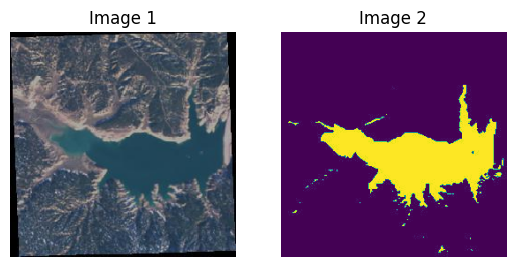

In [31]:
for m1,m2 in train_gen:
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
    plt.imshow(m1[0])
    plt.title('Image 1')
    plt.axis('off')  # Hide axes

    # Plot second image
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
    plt.imshow(m2[0])
    plt.title('Image 2')
    plt.axis('off')  # Hide axes

    # Display the images
    plt.show()
    break

In [49]:
def unet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, 3), dropout_rate=0.3):
    inputs = layers.Input(input_size)

    # First contraction block
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    p1 = layers.Dropout(dropout_rate)(p1)

    # Second contraction block
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    p2 = layers.Dropout(dropout_rate)(p2)

    # Third contraction block
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    p3 = layers.Dropout(dropout_rate)(p3)

    # Bottom layer (bottleneck)
    c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c4)
    c4 = layers.Dropout(dropout_rate)(c4)

    # First expansion block
    u5 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = layers.concatenate([u5, c3])
    c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u5)
    c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c5)
    c5 = layers.Dropout(dropout_rate)(c5)

    # Second expansion block
    u6 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c2])
    c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c6)
    c6 = layers.Dropout(dropout_rate)(c6)

    # Third expansion block
    u7 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c1])
    c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c7)
    c7 = layers.Dropout(dropout_rate)(c7)

    # Output layer
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c7)

    # Model creation
    model = models.Model(inputs=[inputs], outputs=[outputs])

    return model


In [50]:
model = unet_model()
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_45 (Conv2D)        │ (None, 256, 256, 32)   │            896 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_46 (Conv2D)        │ (None, 256, 256, 32)   │          9,248 │ conv2d_45[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_9           │ (None, 128, 128, 32)   │              0 │ conv2d_46[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128, 128, 32)   │              0 │ max_pooling2d_9[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_47 (Conv2D)        │ (None, 128, 128, 64)   │         18,496 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_48 (Conv2D)        │ (None, 128, 128, 64)   │         36,928 │ conv2d_47[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_10          │ (None, 64, 64, 64)     │              0 │ conv2d_48[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64, 64, 64)     │              0 │ max_pooling2d_10[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_49 (Conv2D)        │ (None, 64, 64, 128)    │         73,856 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_50 (Conv2D)        │ (None, 64, 64, 128)    │        147,584 │ conv2d_49[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_11          │ (None, 32, 32, 128)    │              0 │ conv2d_50[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 32, 32, 128)    │              0 │ max_pooling2d_11[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_51 (Conv2D)        │ (None, 32, 32, 256)    │        295,168 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_52 (Conv2D)        │ (None, 32, 32, 256)    │        590,080 │ conv2d_51[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 32, 32, 256)    │              0 │ conv2d_52[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_9        │ (None, 64, 64, 128)    │        131,200 │ dropout_3[0][0]        │
│ (Conv2DTranspose)         │                        │                │                        │
├──────────────────────

 Total params: 1,925,601 (7.35 MB)

 Trainable params: 1,925,601 (7.35 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Calculate steps per epoch for training and validation
steps_per_epoch = (int(len(image_files)/3))//BATCH_SIZE  # Ensure it's the number of batches, not just the number of images
validation_steps = (int(len(image_files)/3))//BATCH_SIZE   # Assuming you have a list or array of validation files

# Train the model with validation
model.fit(train_gen,
          steps_per_epoch=steps_per_epoch,
          epochs=25,
          validation_data=test_gen,
          validation_steps=validation_steps)

Epoch 1/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 34s 781ms/step - accuracy: 0.5876 - loss: 0.6670 - val_accuracy: 0.6974 - val_loss: 0.5159
Epoch 2/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 21s 735ms/step - accuracy: 0.6782 - loss: 0.5499 - val_accuracy: 0.6994 - val_loss: 0.5048
Epoch 3/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 21s 717ms/step - accuracy: 0.6983 - loss: 0.5076 - val_accuracy: 0.7047 - val_loss: 0.4798
Epoch 4/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 688ms/step - accuracy: 0.7016 - loss: 0.4913 - val_accuracy: 0.7078 - val_loss: 0.4753
Epoch 5/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 682ms/step - accuracy: 0.6999 - loss: 0.4913 - val_accuracy: 0.7101 - val_loss: 0.4755
Epoch 6/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 698ms/step - accuracy: 0.7059 - loss: 0.4858 - val_accuracy: 0.7288 - val_loss: 0.4436
Epoch 7/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 19s 669ms/step - accuracy: 0.7372 - loss: 0.4439 - val_accuracy: 0.7480 - val_loss: 0.4166
Epoch 8/25
29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 704ms/step - accuracy: 0.7323 - loss: 0.4387 - val_accu

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


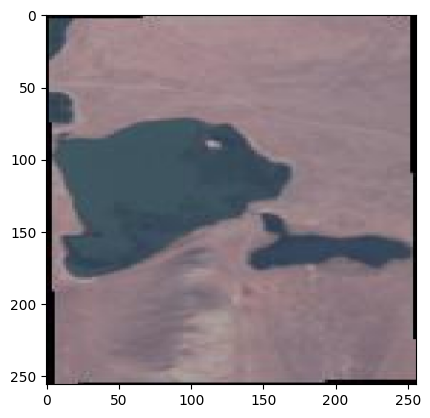

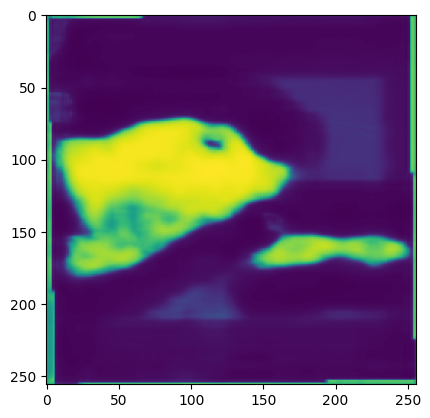

In [54]:
for m1,m2 in train_gen:
    pred = model.predict(m1)
    plt.imshow(m1[0])
    plt.show()
    plt.imshow(pred[0])
    break

In [53]:
pred.shape

(32, 256, 256, 1)